In [248]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [249]:
import pandas as pd
import numpy as np
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import string
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [250]:
def load_dataset():
  column_names = [ 'id', 'text', 'is_humor', 'humor_rating', 'humor_controversy', 'offense_rating' ]
  data_path = '/content/drive/My Drive/data-nlp-humor-offense/train.csv'
  data_frame = pd.read_csv(data_path, names=column_names, skiprows=1, na_values="?", sep=",", skipinitialspace=True)
  data = data_frame.fillna(0).to_numpy()

  return data, data_frame

In [251]:
result, df_result = load_dataset()
print(result[:5])

[[1
  "TENNESSEE: We're the best state. Nobody even comes close. *Elevennessee walks into the room* TENNESSEE: Oh shit..."
  1 2.42 1.0 0.2]
 [2
  'A man inserted an advertisement in the classifieds "Wife Wanted". The next day, he received 1000 of replies, all reading: "You can have mine." Free delivery also available at your door step'
  1 2.5 1.0 1.1]
 [3
  'How many men does it take to open a can of beer? None. It should be open by the time she brings it to the couch.'
  1 1.95 0.0 2.4]
 [4
  "Told my mom I hit 1200 Twitter followers. She pointed out how my brother owns a house and I'm wanted by several collection agencies. Oh ma!"
  1 2.11 1.0 0.0]
 [5
  'Roses are dead. Love is fake. Weddings are basically funerals with cake.'
  1 2.78 0.0 0.1]]


In [252]:
train_data, train_labels = [], []
test_data, test_labels = [], []

humor_yes_data, humor_yes_labels = [], []
humor_no_data, humor_no_labels = [], []

for i in range(0, len(df_result['is_humor'])):
  if df_result['is_humor'][i] == 1:
    humor_yes_data.append(df_result['text'][i])
    humor_yes_labels.append(df_result['is_humor'][i])
  else:
    humor_no_data.append(df_result['text'][i])
    humor_no_labels.append(df_result['is_humor'][i])

output_bias = np.log([len(humor_yes_data)/len(humor_no_data)])

yes_total = len(humor_yes_labels)
no_total = len(humor_no_data)
train_yes = int(0.75 * yes_total)
train_no = int(0.75 * no_total)

train_data_temp = np.concatenate((humor_yes_data[:train_yes], humor_no_data[:train_no]))
train_labels_temp = np.concatenate((humor_yes_labels[:train_yes], humor_no_labels[:train_no]))

test_data_temp = np.concatenate((humor_yes_data[train_yes:], humor_no_data[train_no:]))
test_labels_temp = np.concatenate((humor_yes_labels[train_yes:], humor_no_labels[train_no:]))

train_keys = []
test_keys = []

result_train_map = {}
for index in range(0,len(train_data_temp)):
  result_train_map[index] = {'text': train_data_temp[index], 'label': train_labels_temp[index]}
  train_keys.append(index)

result_test_map = {}
for index in range(0, len(test_data_temp)):
  result_test_map[index] = {'text': test_data_temp[index], 'label': test_labels_temp[index]}
  test_keys.append(index)

random.shuffle(train_keys)
random.shuffle(test_keys)

for key in train_keys:
  train_data.append(result_train_map[key].get('text'))
  train_labels.append(result_train_map[key].get('label'))

for key in test_keys:
  test_data.append(result_test_map[key].get('text'))
  test_labels.append(result_test_map[key].get('label'))

train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

d = {'text': train_data, 'label': train_labels}
train_dataset = pd.DataFrame(data=d)

d = {'text': test_data, 'label': test_labels}
test_dataset = pd.DataFrame(data=d)

In [253]:
VOCAB_SIZE=20000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize='lower_and_strip_punctuation',
    split='whitespace',)
#train_dataset = train_dataset.to_array()
encoder.adapt(train_dataset['text'].to_numpy())

In [254]:
vocab = np.array(encoder.get_vocabulary())

In [255]:
init = tf.constant_initializer(output_bias)

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,kernel_regularizer=tf.keras.regularizers.l2(0.0001), return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [256]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.49838755]


In [257]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.00001),
              metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto')

In [258]:
history = model.fit(train_dataset['text'], train_dataset['label'], epochs=50, validation_split=0.25, verbose=1, callbacks=callback)

Epoch 1/50
141/141 [==============================] - 37s 163ms/step - loss: 0.7197 - accuracy: 0.4899 - val_loss: 0.7182 - val_accuracy: 0.6060
Epoch 2/50
141/141 [==============================] - 18s 129ms/step - loss: 0.7173 - accuracy: 0.6209 - val_loss: 0.7159 - val_accuracy: 0.6033
Epoch 3/50
141/141 [==============================] - 18s 129ms/step - loss: 0.7146 - accuracy: 0.6143 - val_loss: 0.7130 - val_accuracy: 0.6033
Epoch 4/50
141/141 [==============================] - 18s 128ms/step - loss: 0.7113 - accuracy: 0.6223 - val_loss: 0.7096 - val_accuracy: 0.6033
Epoch 5/50
141/141 [==============================] - 18s 130ms/step - loss: 0.7080 - accuracy: 0.6095 - val_loss: 0.7051 - val_accuracy: 0.6033
Epoch 6/50
141/141 [==============================] - 18s 130ms/step - loss: 0.7023 - accuracy: 0.6116 - val_loss: 0.6990 - val_accuracy: 0.6033
Epoch 7/50
141/141 [==============================] - 18s 129ms/step - loss: 0.6953 - accuracy: 0.6125 - val_loss: 0.6914 - val_ac

In [259]:
test_loss, test_acc = model.evaluate(test_dataset['text'], test_dataset['label'], verbose=1)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

63/63 [==============================] - 2s 26ms/step - loss: 0.4256 - accuracy: 0.8485
Test Loss: 0.42561325430870056
Test Accuracy: 0.8485000133514404


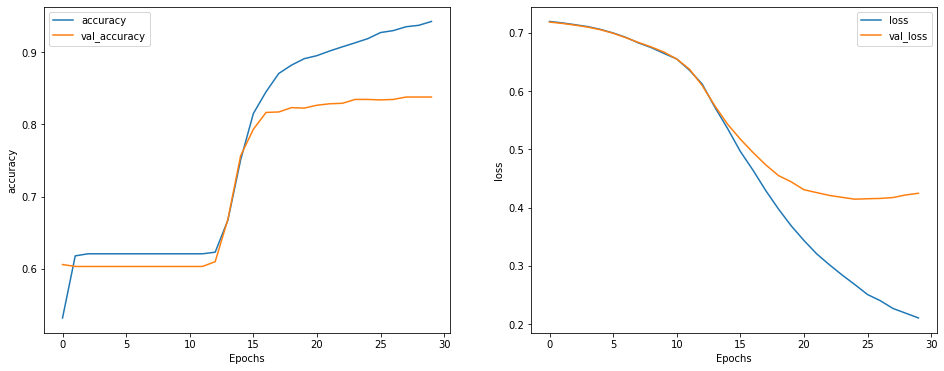

In [260]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [261]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.18210849]
